# Comparing Jaccard and word2vec similarities

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np
import scipy.spatial as sp
import tensorflow as tf

import similarities.loading as sl
import resources.dataset as rd
import resources.queries as rq

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams["figure.figsize"] = (4,4)
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['figure.titlesize']= 'xx-large'
mpl.rcParams['font.size']= 6
mpl.rcParams['image.cmap'] = 'jet'
cmap = cm.get_cmap('jet')
cmap.set_bad('w') # Print bads as white

sess = tf.Session() # tensorflow

### [Aminer Citation Network Datasets - v1 and v9](https://aminer.org/citation)



In [3]:
#data_path = "resources/aminer/v1"
data_path = "resources/aminer/v9"

### Select related documents or not

In [4]:
related_docs = True

### Loading similarity matrices

Each matrix has similarity values between documents in a sample of scientific articles (Aminer), with one of the following measures.

 - word2vec. Mean of similarity of the bag of words in each document.
 - Jaccard. Using bag of words.

In [5]:
# Load sparse matrix with jaccard similarities.
matrix_tmp = sl.load_matrix_jaccard_sim(data_path, related_docs=related_docs)

n = matrix_tmp.shape[0]

matrix_jaccard = tf.constant(matrix_tmp, name='matrix_jaccard')

del matrix_tmp

# Load sparse matrix with word2vec similarities.
matrix_tmp = sl.load_matrix_word2vec_sim(data_path, related_docs=related_docs)

matrix_word2vec = tf.constant(matrix_tmp, name='matrix_word2vec')

del matrix_tmp

pltmask =  np.tri(n, k=-1) # Mask to plot upper triangular matrix.   

# Load document ids in the Same order than the matrices
indexdocs = rd.get_sample_ids(data_path)

print("\nMatrices.")
print(matrix_jaccard)
print(matrix_word2vec)

Loading measures from file ...
 - 502503 measures loaded from resources/aminer/v9/measures-100-10-0-related.bin 
Sample size: 1002 documents
 - Content from resources/aminer/v9/index-data-sample-100-10-0-related.bin
Loading measures from file ...
 - 502503 measures loaded from resources/aminer/v9/measures-100-10-0-related.bin 
Sample size: 1002 documents
 - Content from resources/aminer/v9/index-data-sample-100-10-0-related.bin



Matrices.
Tensor("matrix_jaccard:0", shape=(1002, 1002), dtype=float64)
Tensor("matrix_word2vec:0", shape=(1002, 1002), dtype=float64)


Sample size: 1002 documents
 - Content from resources/aminer/v9/index-data-sample-100-10-0-related.bin


## SVD with TensorFlow

In [6]:
M = tf.Variable(tf.zeros((n,n),  dtype=tf.float64), dtype=tf.float64, name='M') 
s, u, v = tf.svd(M) #SVD

# ns = n
ns = 1 # one singular value

# UDV' matrix reconstruction with ns singular values
M_ = tf.matmul(u[:,:ns], tf.matmul(tf.diag(s[:ns]), v[:,:ns], adjoint_b=True)) 
# M_ = tf.matmul(u[:,:ns], v[:,:ns], adjoint_b=True) # UV'

sess.run(tf.global_variables_initializer())  

print("\nM_ is the reconstruction of the matrix M with %d singular value(s)." % (ns))


M_ is the reconstruction of the matrix M with 1 singular value(s).


### Reconstruction of matrices with singular values

In [7]:
op = M.assign(matrix_jaccard)
sess.run(op)
jaccard_approximation = sess.run(M_) # Reconstruction of the matrix M
jaccard_singular_values = sess.run(s) # Singular values  

op = M.assign(matrix_word2vec)
sess.run(op)
word2vec_approximation = sess.run(M_)
word2vec_singular_values = sess.run(s)

print("Matrix reconstructions using %d singular value(s)" % (ns))

Matrix reconstructions using 1 singular value(s)


From the matrix approximations with SVD is calculated the mean for each column. Later, the means are used to order the matrices.

In [18]:
M = tf.Variable(tf.zeros((n,n),  dtype=tf.float64), dtype=tf.float64, name='M') 
# Means of jaccard similarities using the reconstructed matrix 
means, variances = tf.nn.moments(tf.convert_to_tensor(M), axes=[0])
mean_means, variance_means = tf.nn.moments(means, axes=[0])
sess.run(tf.global_variables_initializer())

op = M.assign(jaccard_approximation)
sess.run(op)

jaccard_means = sess.run(means)
jaccard_mean = sess.run(mean_means)
# Ordered indices by mean of similarities in the approximation
jaccard_indices = jaccard_means.argsort()[::-1]

op = M.assign(word2vec_approximation)
sess.run(op)
# Means of word2vec similarities using the reconstructed matrix 
word2vec_means = sess.run(means)
# Ordered indices by mean of similarities in the approximation
word2vec_indices = word2vec_means.argsort()[::-1]

word2vec_approximation_ordered = word2vec_approximation[:,word2vec_indices][word2vec_indices,:]

## Plots 

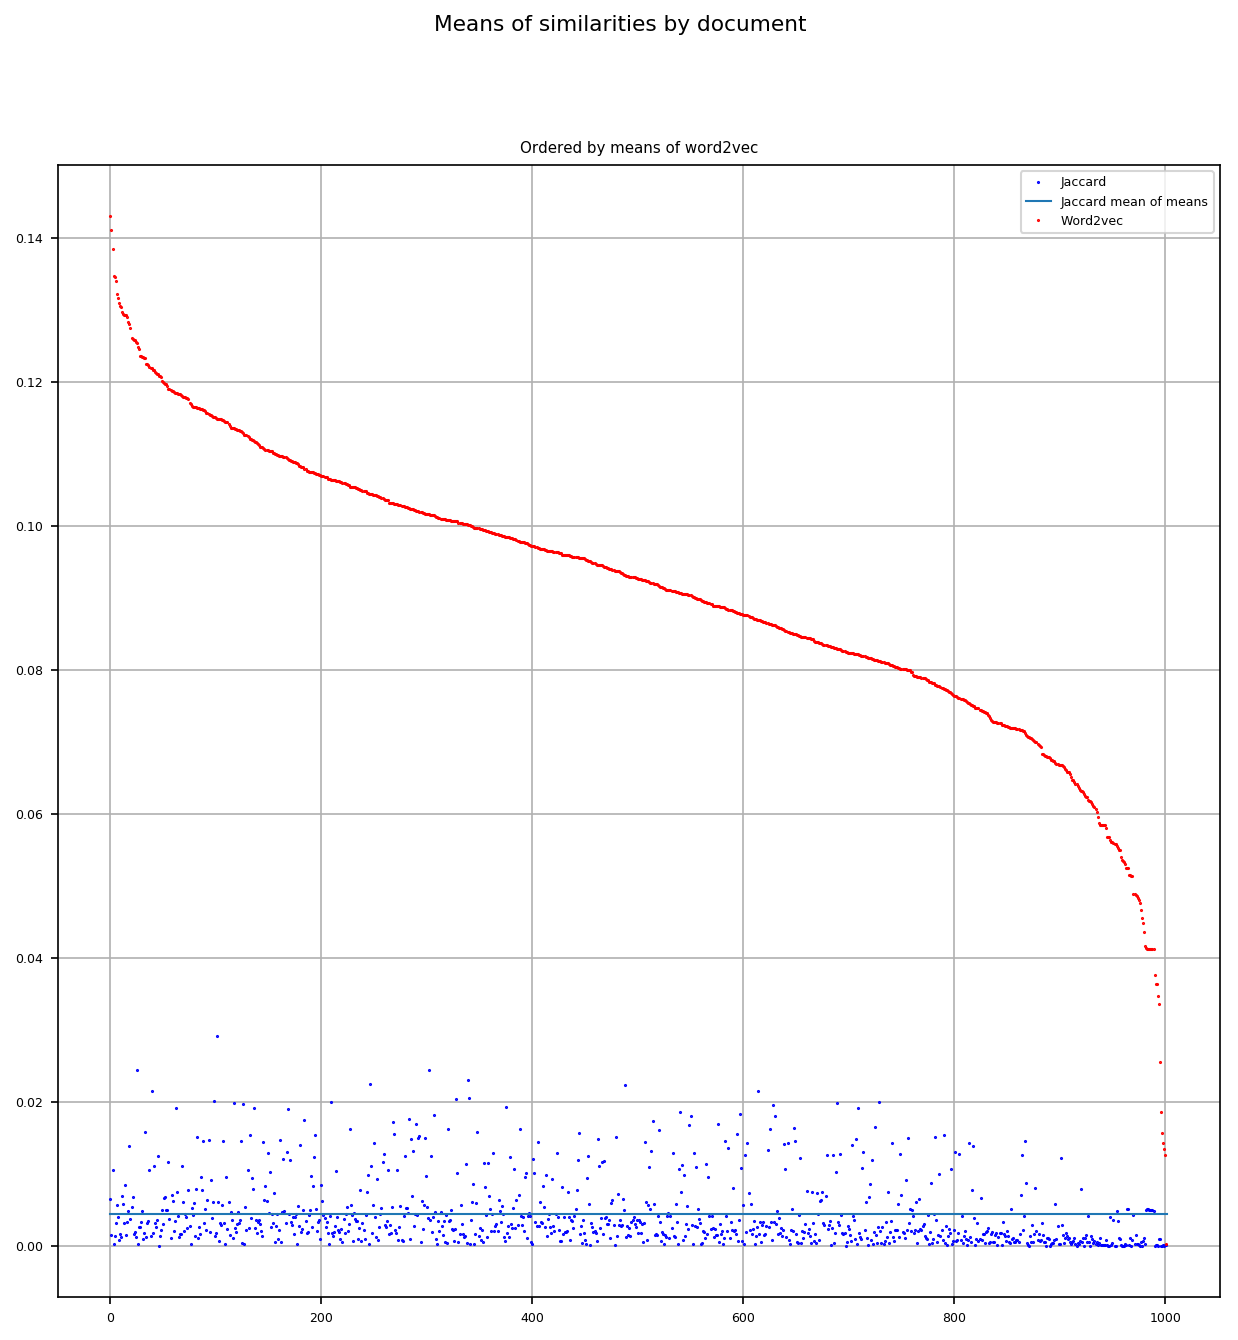

In [19]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Means of similarities by document")

ax_means = plt.subplot(1,1,1)
ax_means.set_title("Ordered by means of word2vec")
#Plotting means of jaccard similarities
ax_means.plot(jaccard_means[word2vec_indices], 'b.', mew=1.0, ms=1.0, label="Jaccard")
ax_means.plot([0,n], [jaccard_mean, jaccard_mean], lw=1.0, label="Jaccard mean of means")
#Plotting means of word2vec similarities
ax_means.plot(word2vec_means[word2vec_indices], 'r.', mew=1.0, ms=1.0, label="Word2vec")

plt.grid(True)
plt.legend()
plt.show()

## Plots submatrices

In [10]:
size_submatrix = int(np.ceil(n/5))
subpltmask = pltmask[:size_submatrix,:size_submatrix]
n_subms = int(np.ceil(n/size_submatrix).tolist())
center_size_submatrix = size_submatrix/2

In [11]:
def plot_submatrices(matrix_to_plot):
    fig = plt.figure(figsize=(12,10))
    
    vmax=matrix_to_plot.max()

    fig.suptitle("(%s x %s)" % (size_submatrix, size_submatrix))

    for i_subimage in range(0, n_subms):
        m_istart = i_subimage * size_submatrix
        m_iend = (i_subimage + 1) * size_submatrix
        j_subimage = i_subimage
        while j_subimage < n_subms:   
            m_jstart = j_subimage * size_submatrix
            m_jend = (j_subimage + 1) * size_submatrix
        
            submatrix_tmp = matrix_to_plot[m_istart:m_iend,m_jstart:m_jend]
            subpltmask_tmp = subpltmask[:submatrix_tmp.shape[0],:submatrix_tmp.shape[0]] if i_subimage == j_subimage else None 
        
            plt.subplot(n_subms, n_subms, j_subimage + (i_subimage*n_subms) + 1)     
            plt.text(center_size_submatrix - 60, 
                        center_size_submatrix + 10, 
                        'test %.5f' % (0.0), 
                        fontsize=10, 
                        color='black',
                        bbox={'facecolor':'white', 'alpha':0.5, 'pad':5}
                   )
        
            im = plt.imshow(
                    np.ma.array(
                        submatrix_tmp, 
                        mask = subpltmask_tmp
                    ),
                    vmin=0.0, vmax=vmax
                )
            j_subimage += 1 

    fig.text(0.3, 0.3, 'some measure = %.5f' % 0.0, ha='center', va='center', size=15)

    plt.show()

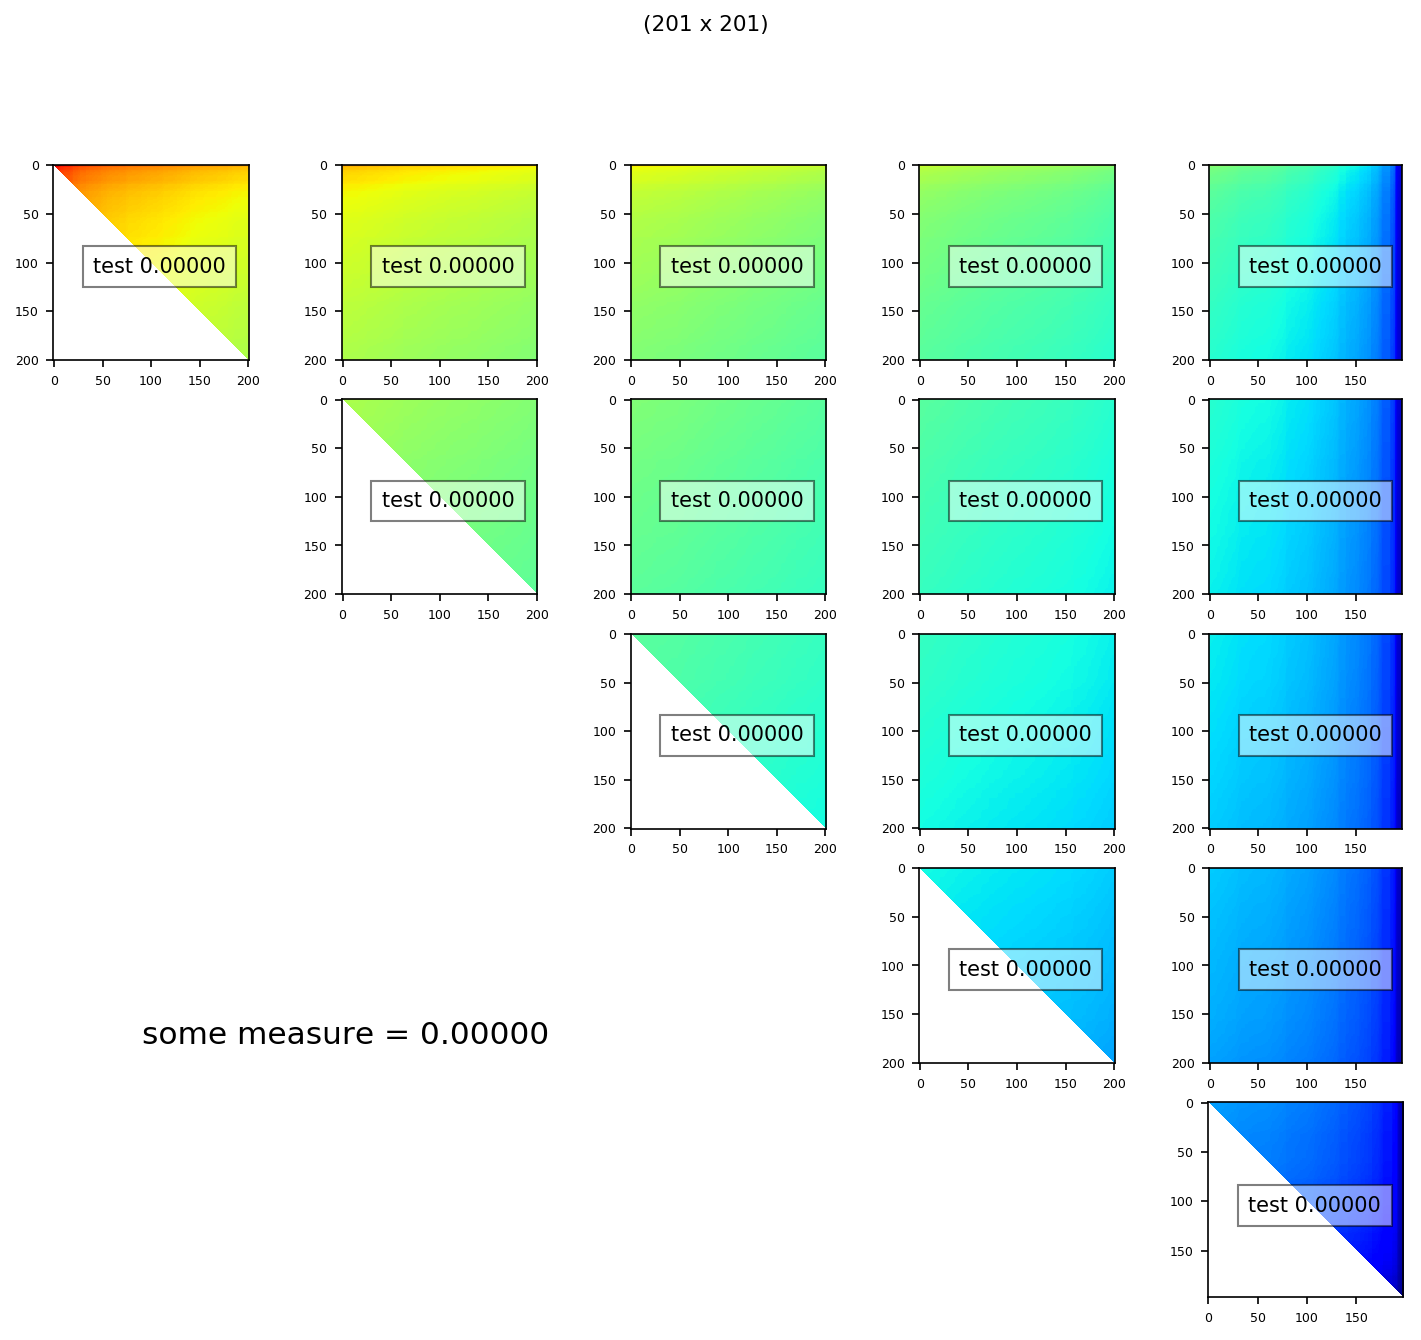

In [12]:
matrix_to_plot = word2vec_approximation_ordered
plot_submatrices(matrix_to_plot)